## Clustering text data with k-means

In [1]:
import pandas as pd                                                  # see below for install instruction
import matplotlib.pyplot as plt                                      # plotting
import numpy as np                                                   # dense matrices
from scipy.sparse import csr_matrix                                  # sparse matrices
from sklearn.preprocessing import normalize                          # normalizing vectors
from sklearn.metrics import pairwise_distances                       # pairwise distances
import sys      
import os
import json
%matplotlib inline

In [2]:
def readJson(path):
    try:
        with open(path, 'r') as f: # Reads the list of most frequent words
            data = json.load(f)
        return data
    except FileNotFoundError:
        raise FileNotFoundError("Please check the path and try again!")

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

wiki = pd.read_csv('people_wiki.csv')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = readJson('people_wiki_map_index_to_word.json')

In [4]:
tf_idf = normalize(tf_idf)

## Implement k-means

In [7]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
        
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:

Assign each data point to the closest centroid.
Revise centroids as the mean of the assigned data points.
**In pseudocode, we iteratively do the following:
<br/>1. cluster_assignment = assign_clusters(data, centroids)
<br/>2. centroids = revise_centroids(data, k, cluster_assignment)
**

Assigning clusters. How do we implement Step 1 of the main k-means loop above? First import pairwise_distances function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See this documentation for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.


In [12]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print ("Pair-wise distances:\n{}".format(dist))
print ("Shape: {}".format(dist.shape))

Pair-wise distances:
[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]
Shape: (59071, 2)


In [18]:
# Test Call
queries = tf_idf[:3,:]
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
dist = dist[430, 1]

if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [31]:
# Test Call
queries = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, queries, metric='euclidean')
closest_cluster = np.argmin(distances, axis=1)

In [33]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [37]:
def calcClusterAssignment(closest_cluster):
    cluster_assignment = {}
    for i in range(len(closest_cluster)):
        docId = i
        clusterId = closest_cluster[i]
        cluster_assignment[docId] = clusterId
        
    return cluster_assignment

cluster_assignment = calcClusterAssignment(closest_cluster)
    

In [52]:
cluster_assignments = np.array(list(cluster_assignment.values()))
if len(cluster_assignments)==59071 and \
   np.array_equal(np.bincount(cluster_assignments), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [54]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [55]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [56]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])
cluster_assignment = assign_clusters(data, centroids)
print (cluster_assignment)   # prints [0 1 0]

[0 1 0]


In [57]:
print (data[cluster_assignment==1])

[[0. 0. 0.]]


In [58]:
print (data[cluster_assignment==0])

[[1. 2. 0.]
 [2. 2. 0.]]


In [59]:
print (data[cluster_assignment==0].mean(axis=0))

[1.5 2.  0. ]


In [60]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [61]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
    np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
    np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


## Assessing convergence
How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as $$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$ The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [62]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

## Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

Repeatedly performs Steps 1 and 2
Tracks convergence metrics
Stops if either no assignment changed or we reach a certain number of iterations.

In [63]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    
    centroids = np.array(initial_centroids.copy())
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print("Iteration: {}/{}".format(itr+1, maxiter))
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment.copy()
        
    return centroids, cluster_assignment

In [64]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Iteration: 1/400
Iteration: 2/400
    19157 elements changed their cluster assignment.
Iteration: 3/400
     7739 elements changed their cluster assignment.
Iteration: 4/400
     5119 elements changed their cluster assignment.
Iteration: 5/400
     3370 elements changed their cluster assignment.
Iteration: 6/400
     2811 elements changed their cluster assignment.
Iteration: 7/400
     3233 elements changed their cluster assignment.
Iteration: 8/400
     3815 elements changed their cluster assignment.
Iteration: 9/400
     3172 elements changed their cluster assignment.
Iteration: 10/400
     1149 elements changed their cluster assignment.
Iteration: 11/400
      498 elements changed their cluster assignment.
Iteration: 12/400
      265 elements changed their cluster assignment.
Iteration: 13/400
      149 elements changed their cluster assignment.
Iteration: 14/400
      100 elements changed their cluster assignment.
Iteration: 15/400
       76 elements changed their cluster assignmen

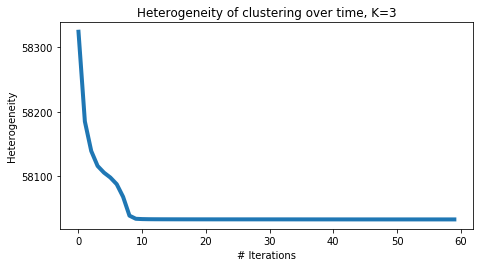

In [65]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [66]:
np.bincount(cluster_assignment)

array([19595, 10427, 29049])

In [69]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster assignment distribution = {2:}'.\
          format(seed, heterogeneity[seed], np.bincount(cluster_assignment)))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442, cluster assignment distribution = [18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=020000, heterogeneity=57533.20100, cluster assignment distribution = [ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=040000, heterogeneity=57512.69257, cluster assignment distribution = [ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=060000, heterogeneity=57466.97925, cluster assignment distribution = [ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=080000, heterogeneity=57494.92990, cluster assignment distribution = [17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=100000, heterogeneity=57484.42210, cluster assignment distribution = [ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=120000, heterogeneity=57554.62410, cluster assignment distribution = [ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]
218.0700080394745


In [73]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [74]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster assignment distribution = {2:}'\
           .format(seed, heterogeneity_smart[seed], np.bincount(cluster_assignment)))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808, cluster assignment distribution = [19618  3857  4173  5219  1743  6900  5530  1348  4384  6299]
seed=020000, heterogeneity=57486.94263, cluster assignment distribution = [ 7132  1726  7419 20581  1941  5121  3777  3741   776  6857]
seed=040000, heterogeneity=57454.35926, cluster assignment distribution = [17602  3415  3535  1736  6445  2552  7106  7155   599  8926]
seed=060000, heterogeneity=57530.43659, cluster assignment distribution = [ 2655  9080  8047  2751 16942  1163  2810  6788  3389  5446]
seed=080000, heterogeneity=57454.51852, cluster assignment distribution = [ 6222  2024  6461  6765  5538 18352  3936  1563  1751  6459]
seed=100000, heterogeneity=57471.56674, cluster assignment distribution = [ 6459  5477  5746 17792  3436  1346  1743  3792  8075  5205]
seed=120000, heterogeneity=57523.28839, cluster assignment distribution = [ 3791  5186  1349 16549  7119  2625  8441  1131  6223  6657]
302.7928569316864


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization. The following code produces a box plot for each of these methods, indicating the spread of values produced by each method.

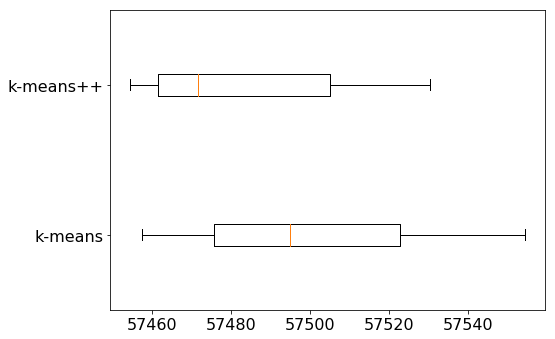

In [76]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [77]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=verbose)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

**The code block below will take about one hour to finish.**

In [78]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

**Using the pre-computed NumPy arrays**

2
10
25
50
100


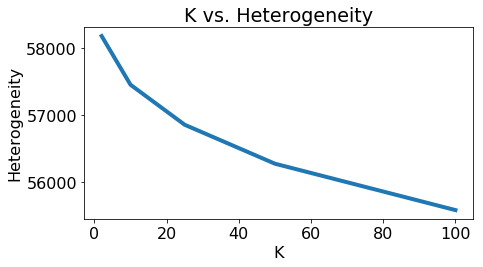

In [79]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print (k)
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

**Visualize clusters of documents**
Let's start visualizing some clustering results to see if we think the clustering makes sense. We can use such visualizations to help us assess whether we have set K too large or too small for a given application. Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

**What are we looking for in a good clustering of documents?**

Documents in the same cluster should be similar.
Documents from different clusters should be less similar.
**<br/>So a bad clustering exhibits either of two symptoms:**
<br/>Documents in a cluster have mixed content.
<br/>Documents with similar content are divided up and put into different clusters.

**To help visualize the clustering, we do the following:**
<br/>Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
<br/>Print titles and first sentences of those nearest neighbors.
<br/>Print top 5 words that have highest tf-idf weights in each centroid.

In [103]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[int(nearest_neighbors[i])]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[int(nearest_neighbors[i])]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [98]:
map_word_to_index = map_index_to_word.copy()
map_index_to_word = {v:k for k,v in map_index_to_word.items()}

In [104]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0    
she:0.025
her:0.017
music:0.012
he:0.011
university:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                         

In [105]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0    
film:0.020
art:0.014
he:0.011
book:0.010
television:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823
  paul swadel is a new


* Lauren Royal                                       0.93445
  lauren royal born march 3 circa 1965 is a book writer from california royal has written bo
  th historic and novelistic booksa selfproclaimed angels baseball fan

* Barbara Hershey                                    0.93496
  barbara hershey born barbara lynn herzstein february 5 1948 once known as barbara seagull 
  is an american actress in a career spanning nearly 50 years

* Janet Jackson                                      0.93559
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Jane Fonda                                         0.93759
  jane fonda born lady jayne seymour fonda december 21 1937 is an american actress writer po
  litical activist former fashion model and fitness guru she is

* Janine Shepherd                                    0.93833
  janine lee shepherd am born 1962 is an australian pilot

In [106]:
np.bincount(cluster_assignment[10])

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926])

In [107]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
law:0.077
district:0.048
court:0.046
republican:0.038
senate:0.038

Cluster 1    
research:0.054
professor:0.033
science:0.032
university:0.031
physics:0.029

Cluster 2    
hockey:0.216
nhl:0.134
ice:0.065
season:0.052
league:0.047

Cluster 3    
party:0.065
election:0.042
elected:0.031
parliament:0.027
member:0.023

Cluster 4    
board:0.025
president:0.023
chairman:0.022
business:0.022
executive:0.020

Cluster 5    
minister:0.160
prime:0.056
cabinet:0.044
party:0.043
election:0.042

Cluster 6    
university:0.044
professor:0.037
studies:0.035
history:0.034
philosophy:0.031

Cluster 7    
election:0.066
manitoba:0.058
liberal:0.051
party:0.045
riding:0.043

Cluster 8    
racing:0.095
formula:0.056
championship:0.054
race:0.052
poker:0.051

Cluster 9    
economics:0.146
economic:0.096
economist:0.053
policy:0.048
research:0.043

Cluster 10    
championships:0.075
olympics:0.050
marathon:0.048
metres:0.048
she:0.048

Cluster 11    
she:0.144
her:0.092
miss:0.016
actress:0

In [108]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0    
brazilian:0.137
brazil:0.082
de:0.056
rio:0.053
paulo:0.050

Cluster 1    
bishop:0.170
diocese:0.085
archbishop:0.083
church:0.072
ordained:0.058

Cluster 2    
zealand:0.247
new:0.069
auckland:0.056
wellington:0.031
zealands:0.029

Cluster 3    
comics:0.181
comic:0.121
strip:0.042
graphic:0.036
book:0.034

Cluster 4    
puerto:0.309
rico:0.220
rican:0.066
juan:0.041
ricos:0.031

Cluster 5    
bbc:0.192
radio:0.127
presenter:0.054
show:0.046
news:0.042

Cluster 6    
senate:0.059
district:0.053
county:0.051
committee:0.049
state:0.044

Cluster 7    
labor:0.105
australian:0.099
liberal:0.071
election:0.067
seat:0.061

Cluster 8    
economics:0.065
university:0.048
research:0.045
professor:0.043
economic:0.043

Cluster 9    
foreign:0.086
ambassador:0.076
affairs:0.061
nations:0.053
united:0.040

Cluster 10    
she:0.188
her:0.052
women:0.026
womens:0.020
council:0.019

Cluster 11    
rowing:0.246
sculls:0.097
rower:0.081
olympics:0.073
championships:0.068

Cluster 12   

dj:0.093
hop:0.052
hip:0.051
music:0.048
album:0.037

Cluster 60    
de:0.127
la:0.059
el:0.035
mexico:0.026
y:0.025

Cluster 61    
jewish:0.193
rabbi:0.132
israel:0.052
hebrew:0.038
jews:0.032

Cluster 62    
ballet:0.362
dance:0.109
dancer:0.084
she:0.057
danced:0.044

Cluster 63    
hockey:0.220
nhl:0.138
ice:0.067
season:0.053
league:0.048

Cluster 64    
law:0.148
court:0.093
judge:0.071
district:0.051
justice:0.043

Cluster 65    
coach:0.205
head:0.086
basketball:0.059
coaching:0.052
football:0.046

Cluster 66    
armenian:0.278
armenia:0.168
yerevan:0.100
sargsyan:0.055
genocide:0.031

Cluster 67    
album:0.088
released:0.044
music:0.040
records:0.033
albums:0.027

Cluster 68    
she:0.158
her:0.152
music:0.020
album:0.016
singer:0.013

Cluster 69    
theatre:0.194
directed:0.034
production:0.031
play:0.029
actor:0.027

Cluster 70    
health:0.099
medical:0.089
medicine:0.086
research:0.039
clinical:0.039

Cluster 71    
european:0.145
parliament:0.115
party:0.053
member:0.04

In [109]:
np.bincount(cluster_assignment[100])

array([ 241,  346,  207,  207,   95,  286,  683,  394,  947,  446,  875,
         73,  374,  724,  299,  124,  679,  324, 1066,  622,  402,  428,
        141,  545,  549,  157,   34,  408,  397,   41, 1419,  722, 2025,
        301,  174,  297,  846, 1010,  348,   66,  690,  638, 1286,  488,
        931, 1480,  259,  338,  224,  504,  225,  165,  310,  110,  421,
         89,  190, 1379,   63,  433,  467,  194,  121,  569,  979,  535,
         43, 1291, 1274,  574,  670,  165,  155,  555, 1964,  175,  149,
        587,  133,  260, 5563,  257, 1146,  695,  402, 1497,  185,  477,
       1024,  256,  650, 1024,  500, 1393,  756, 1109, 1032,  182,  180,
        338])

In [113]:
sum(np.bincount(cluster_assignment[100])<236)

29